In [ ]:
!pip install sentencepiece


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.8 MB/s eta 0:00:00


In [ ]:
!pip install latex


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for latex: filename=latex-0.7.0-py3-none-any.whl size=7587 sha256=64fd90e407933070efec1c80d3f3baeb9186af9470f6755f45a4afe297bd1bce
  Stored in directory: /root/.cache/pip/wheels/7e/02/25/c00dfc203e8ba53dfc2e4e97d40e537263d6e03606681f3872
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7227 sha256=f71e7cf058c3076d709175877ddf7a451976948478de15d4956b1f928c2ca398
  Stored in directory: /root/.cache/pip/wheels/d0/e8/fa/e253c256048ea58d99a8abb5e751abb6a838af6f12887b5418
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-py3-none-any.whl size=2766 sha256=7309931c698ab9af9e9fda9ad52d90855500400ffe633b38e243f8e8cdfad1f1
  Stored in directory: /root/.cache/pip/wheels/75/1f/1c/0ecab7ceabad0b8e01

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.5 MB/s eta 0:00:00


In [ ]:
import math
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import torch
from google.colab import files

# returns Bm, Vm whose meaning is this:
# 
# x_i (t+1) = x_i(t) + \sum_m \sum_j 1/Z_{i,m} exp(<x_i, Bm x_j>) Vm x_j
#
# Here tokens are normalized so that ||x_i||=\sqrt{d_model} (i.e. not on a unit sphere).
#
def albert_get_BV(al_model, head_idx=0):
    al_transfo = al_model.encoder;
    al_layer = al_transfo.albert_layer_groups[0].albert_layers[0];
    al_attention = al_layer.attention;
    
    # These matrices that act on token x (row-vector) by x \times WQ etc 
    WQ = al_attention.query.weight.T;
    WV = al_attention.value.weight.T;
    WK = al_attention.key.weight.T;
    D = al_attention.dense.weight.T;
    
    dk = al_attention.attention_head_size; 
    dmodel = al_attention.hidden_size;
    m = head_idx;
    
    
    WQm = WQ[:, (dk*m):(dk*m + dk)]; WKm = WK[:, (dk*m):(dk*m + dk)]; 
    WVm = torch.zeros(dmodel,dmodel);
    WVm[:, (dk*m):(dk*m + dk)] = WV[:, (dk*m):(dk*m + dk)]; 
    
    # bilinear form matrix
    b_mtx = torch.matmul(WQm, WKm.T); b_mtx = 0.5* (b_mtx + b_mtx.T) / math.sqrt(dk);
    
    # Convert value matrix to a matrix acting on tokens as column vectors:
    value_mtx = torch.matmul(WVm, D).T; 
    
    return b_mtx.clone().detach(), value_mtx.clone().detach();


def plot_B_spectra(al_model):
    assert(al_model.config.num_attention_heads == 16) | (al_model.config.num_attention_heads == 1) ;

    print('Note that these matrices act on token vectors normalized to ||x||=sqrt(2048)')
    
    if al_model.config.num_attention_heads == 16:
        heads = 16;
        fig, axes = plt.subplots(4, 4);
        axes = axes.flatten();
    elif al_model.config.num_attention_heads == 1:
        heads = 1;
        fig, axes = plt.subplots(1);
        axes = [axes,];
    else:
        raise AssertionError('num heads');
    
    minx = 0; maxx = 0;
    
    betas = [];
    dmodel = al_model.config.hidden_size;
    assert(dmodel == 2048);
    
    for i in range(heads):
        B, _ = albert_get_BV(al_model, i);
        eigs = torch.linalg.eigvalsh(B); 
        eigs = eigs[eigs.abs() > 1e-6]; 
        
        if heads == 16:
            assert len(eigs) == 256;

        axes[i].hist(eigs,bins=40, density=True);
        axes[i].set_title(f'head {i}');
        axes[i].set_ylim(0,8);
        
        minx = min(minx, eigs.min());
        maxx = max(maxx, eigs.max());
        
        eff_beta = math.sqrt((B.flatten()**2).sum() * dmodel);
        betas += [eff_beta,];
        
    for i in range(heads):
        axes[i].set_xlim(minx,maxx)
    
    #  This is computed as that beta which would yield the same typical RMSE value (for a pair of indep isotropic token)
    #  in the model with exp(<x_i, x_j>\beta / d_model), where again x_i has N(0,1) coordinates.
    print('Effective betas = ', betas)
    
    
def plot_V_spectra(al_model):
    assert(al_model.config.num_attention_heads == 16) | (al_model.config.num_attention_heads == 1) ;

    print('Note that these matrices act on token vectors normalized to ||x||=sqrt(2048)')
    
    if al_model.config.num_attention_heads == 16:
        heads = 16;
        #fig, axes = plt.subplots(4,4);
        #axes = axes.flatten();
    else:
        raise AssertionError('num heads');
    
    minx = 0; maxx = 0;
    
    dmodel = al_model.config.hidden_size;
    assert(dmodel == 2048);
  
    
    for i in range(heads):
        _, V = albert_get_BV(al_model, i);
        eigs = torch.linalg.eigvals(V); 
        eigs = eigs[eigs.abs() > 1e-4]; 
        
        if heads == 16:
            print(f'Head = {i}, non-zero eigs = {len(eigs)}')
            #assert len(eigs) == 128;

        minx = min(minx, eigs.real.min());
        maxx = max(maxx, eigs.real.max());

        plt.figure()
        #plt.plot(eigs.real, eigs.imag, 'k.');

        label_size = 16
        plt.rcParams['xtick.labelsize'] = label_size
        plt.rcParams['ytick.labelsize'] = label_size

        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)

        plt.grid(color='silver', linestyle=':', linewidth=0.15, zorder=3)
        plt.gca().set_axisbelow(True)


        #print(eigs.real.shape)
        plt.scatter([x for x in eigs.real], 
                    [x for x in eigs.imag], 
                    color='crimson', 
                    linewidth=0.75, 
                    edgecolors='black')
        title = 'Eigenvalues of value matrix for head %s' % int(i+1)
        plt.title(title);
        plt.xlim(-2.25-0.1, 1.5+0.1)
        plt.ylim(-1.5-0.1, 1.5+0.1)
        plt.gca().set_aspect('equal', adjustable='box')
        #axes[i].set_ylim(0,8);
        
        base_filename = "eigs" + "{}.pdf".format(i+1)
        print(i)
        plt.savefig(base_filename, 
                    format='pdf', 
                    bbox_inches='tight')
        files.download(base_filename)
        plt.show()
        plt.clf()
        plt.close()
            

Some weights of the model checkpoint at albert-xlarge-v2 were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Note that these matrices act on token vectors normalized to ||x||=sqrt(2048)
Head = 0, non-zero eigs = 128
0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

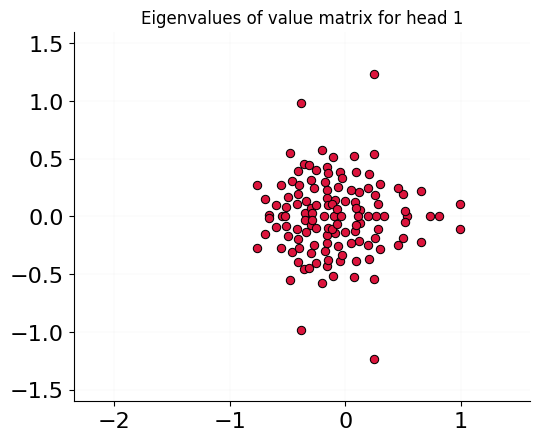

Head = 1, non-zero eigs = 128
1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

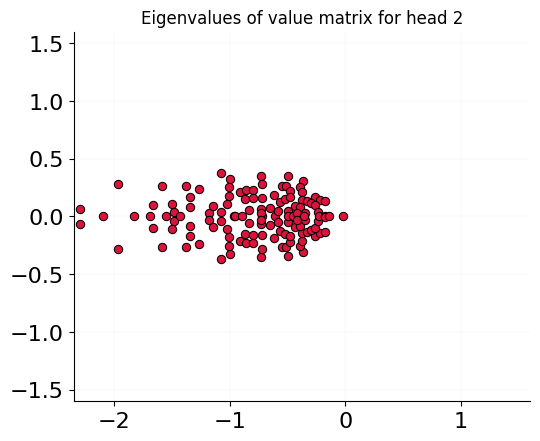

Head = 2, non-zero eigs = 128
2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

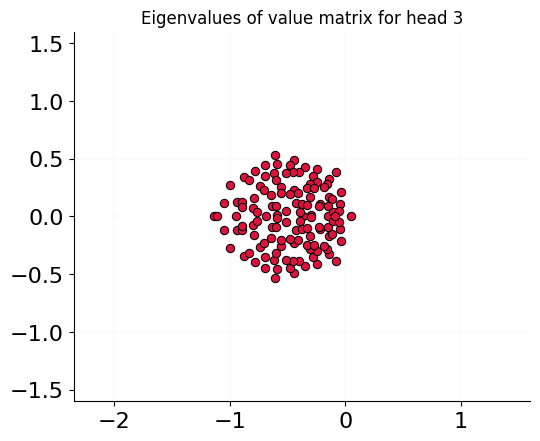

Head = 3, non-zero eigs = 128
3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

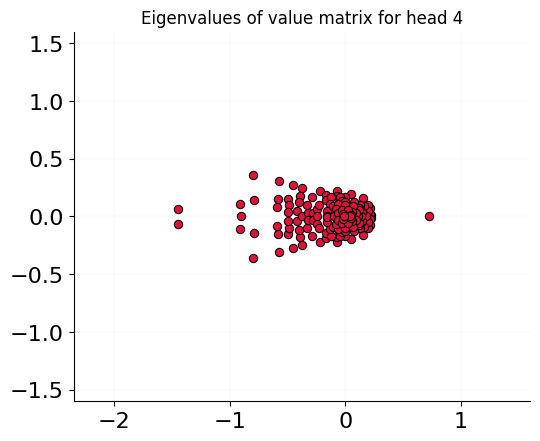

Head = 4, non-zero eigs = 128
4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

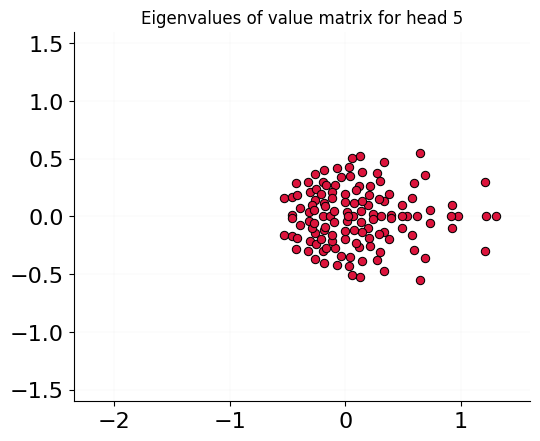

Head = 5, non-zero eigs = 128
5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

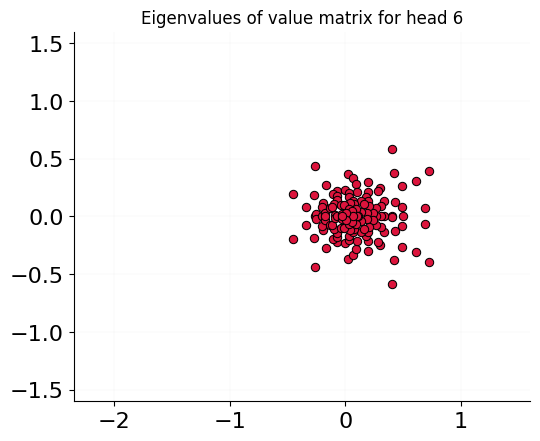

Head = 6, non-zero eigs = 128
6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

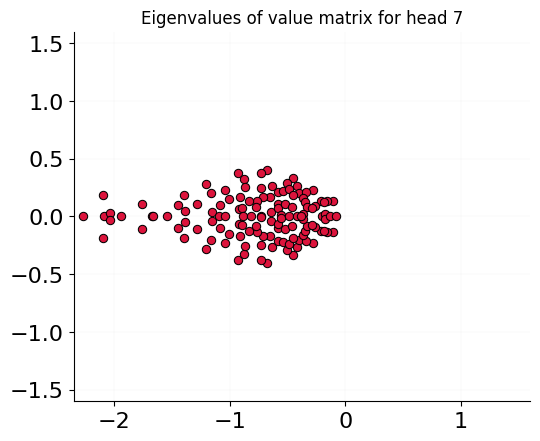

Head = 7, non-zero eigs = 128
7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

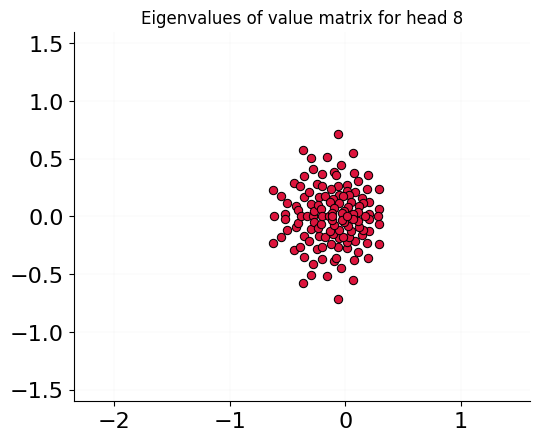

Head = 8, non-zero eigs = 128
8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

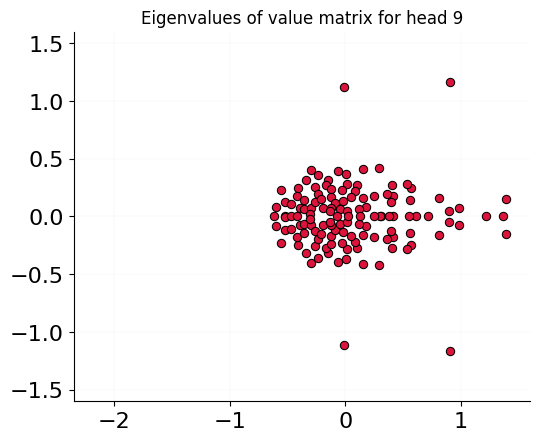

Head = 9, non-zero eigs = 128
9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

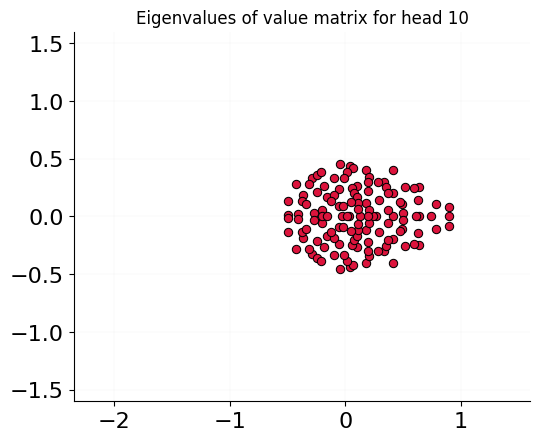

Head = 10, non-zero eigs = 128
10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

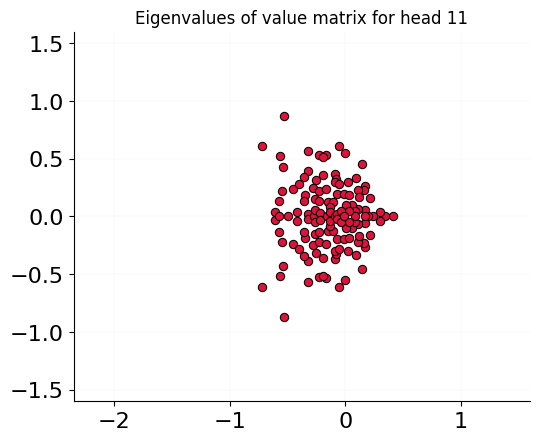

Head = 11, non-zero eigs = 128
11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

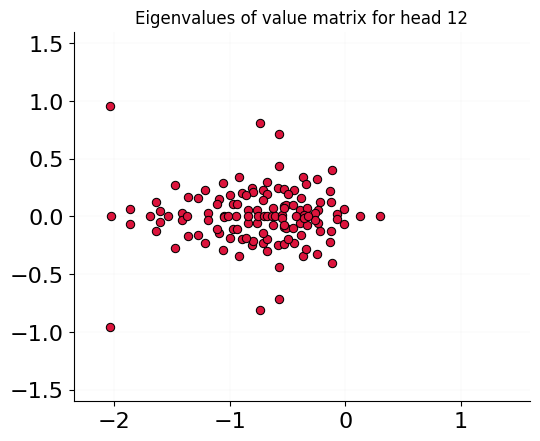

Head = 12, non-zero eigs = 128
12


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

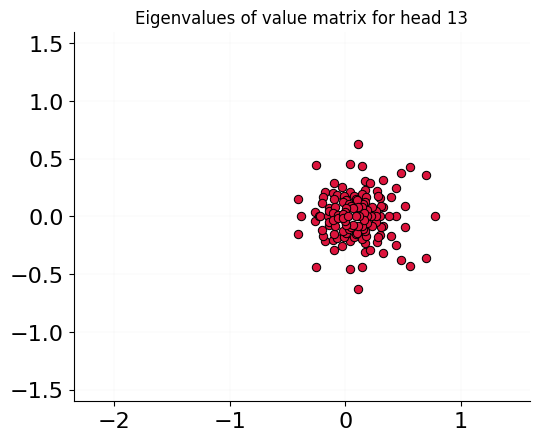

Head = 13, non-zero eigs = 128
13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

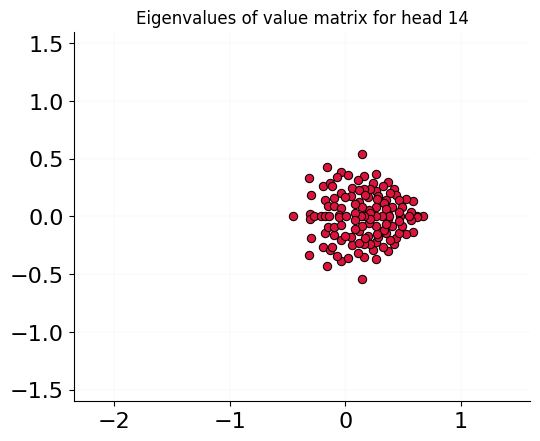

Head = 14, non-zero eigs = 128
14


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

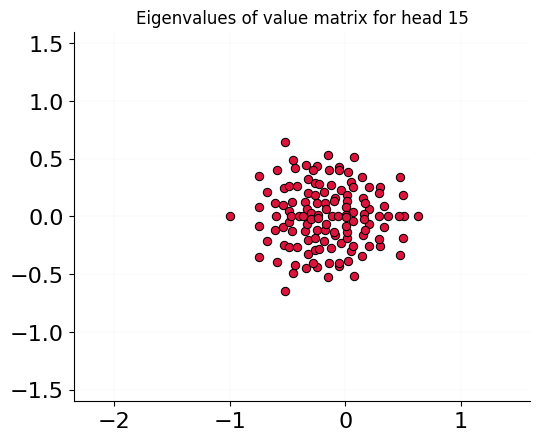

Head = 15, non-zero eigs = 128
15


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

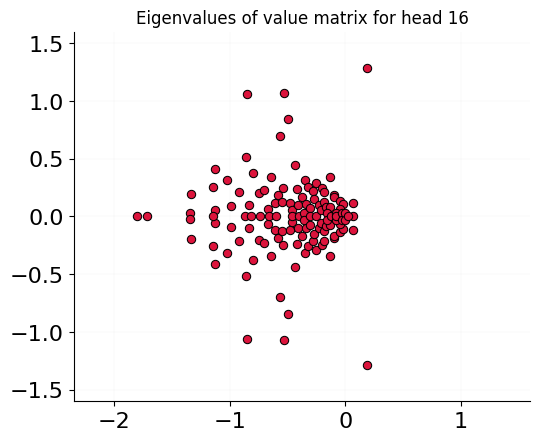

In [ ]:
from transformers import AlbertTokenizer, AlbertModel
#tokenizer = AlbertTokenizer.from_pretrained('albert-xlarge-v2')
al_model = AlbertModel.from_pretrained("albert-xlarge-v2")
    
plot_V_spectra(al_model)

In [ ]:
files.download("eigs11.pdf")
files.download("eigs12.pdf")
files.download("eigs13.pdf")
files.download("eigs14.pdf")
files.download("eigs15.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>